## Imports

In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [3]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint

import sys
sys.path.insert(0, '..')
from metrics import IoU_metric, dice_metric, precision_metric, recall_metric
from loss_functions import focal_dice_loss
from data_loader import make_dataset
from data_augmentation import smart_crop, random_geometric_augment, filter_nofire_fraction

## Backbone


In [8]:
def build_CNN_AE_model() -> Model:
    """
    Create CNN auto encode model.

    Returns:
        (Model): Keras model.
    """
    base_model = tf.keras.applications.MobileNetV2(input_shape=[32, 32, 12],
                                                   include_top=False,
                                                   weights=None)


    # Use the activations of these layers
    layer_names = [
        'block_1_expand_relu',   # 32x32
        'block_3_expand_relu',   # 16x16
        'block_6_expand_relu',   # 8x8
        'block_13_expand_relu',  # 4x4
        'block_16_project',      # 2x2
    ]
    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

    # Create the feature extraction model
    down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

    down_stack.trainable = True

    up_stack = [
        pix2pix.upsample(512, 3),  # 2x2 -> 4x4
        pix2pix.upsample(256, 3),  # 4x4 -> 8x8
        pix2pix.upsample(128, 3),  # 8x8 -> 16x16
        pix2pix.upsample(64, 3),   # 16x16 -> 32x32
    ]

    inputs = tf.keras.layers.Input(shape=[32, 32, 12])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=2,
    padding='same')  #64x64 -> 128x128

    x = last(x)
    outputs = Conv2D(1, 1, padding='same', activation='sigmoid')(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [9]:
segmentation_model = build_CNN_AE_model()
segmentation_model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 32, 32,    │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_12       │ [(None, 16, 16,   │  1,844,576 │ input_layer_13[0… │
│ (Functional)        │ 96), (None, 8, 8, │            │                   │
│                     │ 144), (None, 4,   │            │                   │
│                     │ 4, 192), (None,   │            │                   │
│                     │ 2, 2, 576),       │            │                   │
│                     │ (None, 1, 1,      │            │                   │
│                     │ 320)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 2, 2, 512) │  1,476,608 │ functional_12[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 2, 2,      │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 1088)             │            │ functional_12[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 4, 4, 256) │  2,507,776 │ concatenate_8[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 4, 4, 448) │          0 │ sequential_9[0][… │
│ (Concatenate)       │                   │            │ functional_12[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 8, 8, 128) │    516,608 │ concatenate_9[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 8, 8, 272) │          0 │ sequential_10[0]… │
│ (Concatenate)       │                   │            │ functional_12[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 16, 16,    │    156,928 │ concatenate_10[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 16, 16,    │          0 │ sequential_11[0]… │
│ (Concatenate)       │ 160)              │            │ functional_12[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_14 │ (None, 32, 32, 1) │      1,441 │ concatenate_11[0… │
│ (Conv2DTranspose)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32, 1) │          2 │ conv2d_transpose… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,503,939 (24.81 MB)

 Trainable params: 6,471,107 (24.69 MB)

 Non-trainable params: 32,832 (128.25 KB)

## Transfer Learning Model

In [11]:
# 1. load pre-trained model
backbone = build_CNN_AE_model()          # input: (32, 32, 12)
backbone.load_weights("best.h5")
print("Loaded backbone weights from best.h5")

# 2. *selectively* freeze backbone
backbone.trainable = True

for layer in backbone.layers:
    if hasattr(layer, 'name'):
        if any(x in layer.name for x in ['block_', 'Conv1', 'bn_', 'mobilenetv2']):
            layer.trainable = False
        else:
            layer.trainable = True

# 3. adapt to new 18 band input
inputs_18 = tf.keras.Input(shape=(32, 32, 18), name="input_18bands")

# 4. 18 → 12 1×1 Conv
x12 = tf.keras.layers.Conv2D(
    filters=12,
    kernel_size=1,
    padding="same",
    name="adapter_18to12"
)(inputs_18)

# 5. 12 band throw to segmentation backbone
outputs = backbone(x12)

# 6. construct new transfer model
transfer_model = tf.keras.Model(
    inputs=inputs_18,
    outputs=outputs,
    name="wildfire_transfer_18bands"
)

# 7. compile
transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=focal_dice_loss,
    metrics=[
        IoU_metric,
        dice_metric,
        precision_metric,
        recall_metric,
    ]
)

transfer_model.summary()

Loaded backbone weights from best.h5


Model: "wildfire_transfer_18bands"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_18bands (InputLayer)      │ (None, 32, 32, 18)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ adapter_18to12 (Conv2D)         │ (None, 32, 32, 12)     │           228 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_29 (Functional)      │ (None, 32, 32, 1)      │     6,503,939 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,504,167 (24.81 MB)

 Trainable params: 6,471,335 (24.69 MB)

 Non-trainable params: 32,832 (128.25 KB)

## Create Datasets

In [12]:
import os
current_dir = os.getcwd()
credentials_path = os.path.join(current_dir, '..', '.credentials', 'gcp_key.json')
credentials_path = os.path.abspath(credentials_path)

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credentials_path

In [13]:
data_dir = "gs://firespreadpredictiontest/processed_data/bc_wildfire"
batch_size = 64

In [14]:
def smart_crop_wrapper(x, y):
    """
    TensorFlow wrapper for smart_crop function with extensive debugging.
    """
    def _smart_crop_py(x, y):
        try:
            x_np = x.numpy()
            y_np = y.numpy()

            result = smart_crop(
                x_np, y_np,
                target_height=32,
                target_width=32,
                neg_crop_mode="center",
                min_context_margin=0.5
            )

            if result is None:
                print("ERROR: smart_crop returned None!")
                raise ValueError("smart_crop returned None")

            cropped_x, cropped_y = result

            if cropped_x is None or cropped_y is None:
                print(f"ERROR: One of the outputs is None! cropped_x: {cropped_x}, cropped_y: {cropped_y}")
                raise ValueError("smart_crop returned None for one of the outputs")

            return cropped_x.astype('float32'), cropped_y.astype('float32')

        except Exception as e:
            print(f"EXCEPTION in smart_crop_wrapper: {e}")
            import traceback
            traceback.print_exc()
            raise

    cropped_x, cropped_y = tf.py_function(
        _smart_crop_py,
        [x, y],
        [tf.float32, tf.float32]
    )

    cropped_x.set_shape([32, 32, 18])
    cropped_y.set_shape([32, 32, 1])

    return cropped_x, cropped_y

In [15]:
train_ds1 = (make_dataset(data_dir,
                         mode = "train", shuffle = True, batching = False)
             .map(random_geometric_augment, num_parallel_calls=tf.data.AUTOTUNE))
train_ds2 = (make_dataset(data_dir,
                         mode = "train", shuffle = True, batching = False)
             .map(random_geometric_augment, num_parallel_calls=tf.data.AUTOTUNE))
all_fire = (make_dataset(data_dir,
                         mode = "train", shuffle = True, batching = False)
            .map(random_geometric_augment, num_parallel_calls=tf.data.AUTOTUNE)
            .concatenate(train_ds1).concatenate(train_ds2))
no_fire = (make_dataset(data_dir,
                         mode = "train", shuffle = True, batching = False)
           .filter(lambda x, y: filter_nofire_fraction(x, y, keep_ratio = 0.3)))
train_ds = (all_fire.concatenate(no_fire).map(smart_crop_wrapper).shuffle(2000)
            .batch(batch_size).prefetch(tf.data.AUTOTUNE))

train: found 5795 tif files
train: found 5795 tif files
train: found 5795 tif files
train: found 5795 tif files


In [16]:
val_ds = (make_dataset(data_dir, mode="val", shuffle=False, batching = False)
          .map(smart_crop_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
          .batch(batch_size)
          .prefetch(tf.data.AUTOTUNE))

val: found 829 tif files


In [17]:
print("Testing pipeline...")
for x_batch, y_batch in train_ds.take(1):
    print(f"Batch shapes: x={x_batch.shape}, y={y_batch.shape}")
    print(f"x range: [{x_batch.numpy().min()}, {x_batch.numpy().max()}]")
    print(f"y range: [{y_batch.numpy().min()}, {y_batch.numpy().max()}]")
    print("Pipeline test successful!")

Testing pipeline...


2025-12-10 08:21:30.096062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 47 of 2000
2025-12-10 08:21:50.022262: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 317 of 2000
2025-12-10 08:22:10.005152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 805 of 2000
2025-12-10 08:22:20.051940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1141 of 2000
2025-12-10 08:22:40.063511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1756 of 2000
2025-12-10 08:22:45.558340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


Batch shapes: x=(64, 32, 32, 18), y=(64, 32, 32, 1)
x range: [-717.0, 2785.09375]
y range: [0.0, 1.0]
Pipeline test successful!


2025-12-10 08:22:49.919581: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## Training

In [18]:
checkpoint = ModelCheckpoint(
    "best_transfer_model.h5",              # file name
    monitor="val_loss",           # assess by loss index
    save_best_only=True,          # save the best
    mode="min",
    verbose=1
)

history = transfer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[checkpoint],
)

Epoch 1/20


2025-12-10 08:25:09.101791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 275 of 2000
2025-12-10 08:25:19.260509: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 657 of 2000
2025-12-10 08:25:39.053117: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1288 of 2000
2025-12-10 08:25:49.093846: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1647 of 2000
2025-12-10 08:26:00.261985: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
I0000 00:00:1765383962.019247  825485 service.cc:145] XLA service 0x7980b4019460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765383962.019324  825485 se

    329/Unknown 739s 2s/step - dice_metric: 0.0138 - io_u_metric: 0.0070 - loss: 0.8038 - precision_metric: 0.0072 - recall_metric: 0.2109

2025-12-10 08:37:13.177455: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng46{k2=6,k5=2,k14=2} for conv (f32[1,960,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,37440,1,1]{3,2,1,0}, f32[960,39,1,1]{3,2,1,0}), window={size=1x1 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2025-12-10 08:37:13.998076: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.823581172s
Trying algorithm eng46{k2=6,k5=2,k14=2} for conv (f32[1,960,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,37440,1,1]{3,2,1,0}, f32[960,39,1,1]{3,2,1,0}), window={size=1x1 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operat

    331/Unknown 760s 2s/step - dice_metric: 0.0139 - io_u_metric: 0.0070 - loss: 0.8027 - precision_metric: 0.0072 - recall_metric: 0.2118

2025-12-10 08:37:22.706692: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-10 08:37:22.706950: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/home/claireb/miniconda3/envs/5330_final/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from None to 0.56214, saving model to best_transfer_model.h5


331/331 ━━━━━━━━━━━━━━━━━━━━ 816s 2s/step - dice_metric: 0.0255 - io_u_metric: 0.0130 - loss: 0.6262 - precision_metric: 0.0133 - recall_metric: 0.3538 - val_dice_metric: 0.0472 - val_io_u_metric: 0.0242 - val_loss: 0.5621 - val_precision_metric: 0.0263 - val_recall_metric: 0.3082
Epoch 2/20


2025-12-10 08:38:28.909115: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 289 of 2000
2025-12-10 08:38:38.777044: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 672 of 2000
2025-12-10 08:38:58.833152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1295 of 2000
2025-12-10 08:39:08.768281: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1634 of 2000
2025-12-10 08:39:20.374660: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


329/331 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - dice_metric: 0.0512 - io_u_metric: 0.0263 - loss: 0.1826 - precision_metric: 0.0266 - recall_metric: 0.7306 

2025-12-10 08:51:00.263738: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng46{k2=6,k5=2,k14=2} for conv (f32[1,960,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,59520,1,1]{3,2,1,0}, f32[960,62,1,1]{3,2,1,0}), window={size=1x1 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2025-12-10 08:51:00.524387: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.312321125s
Trying algorithm eng46{k2=6,k5=2,k14=2} for conv (f32[1,960,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,59520,1,1]{3,2,1,0}, f32[960,62,1,1]{3,2,1,0}), window={size=1x1 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operat

331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_metric: 0.0512 - io_u_metric: 0.0264 - loss: 0.1824 - precision_metric: 0.0266 - recall_metric: 0.7306

2025-12-10 08:51:07.669420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-10 08:51:07.670197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 2: val_loss improved from 0.56214 to 0.32154, saving model to best_transfer_model.h5


331/331 ━━━━━━━━━━━━━━━━━━━━ 799s 2s/step - dice_metric: 0.0571 - io_u_metric: 0.0295 - loss: 0.1418 - precision_metric: 0.0298 - recall_metric: 0.7310 - val_dice_metric: 0.0553 - val_io_u_metric: 0.0285 - val_loss: 0.3215 - val_precision_metric: 0.0293 - val_recall_metric: 0.5220
Epoch 3/20


2025-12-10 08:51:47.744542: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 287 of 2000
2025-12-10 08:51:57.692143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 601 of 2000
2025-12-10 08:52:08.361820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 928 of 2000
2025-12-10 08:52:27.696721: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1563 of 2000
2025-12-10 08:52:41.295966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


330/331 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - dice_metric: 0.0541 - io_u_metric: 0.0279 - loss: 0.1340 - precision_metric: 0.0281 - recall_metric: 0.7479

2025-12-10 09:04:51.370700: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng46{k2=6,k5=2,k14=2} for conv (f32[1,960,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,40320,1,1]{3,2,1,0}, f32[960,42,1,1]{3,2,1,0}), window={size=1x1 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2025-12-10 09:04:51.690215: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.322368082s
Trying algorithm eng46{k2=6,k5=2,k14=2} for conv (f32[1,960,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,40320,1,1]{3,2,1,0}, f32[960,42,1,1]{3,2,1,0}), window={size=1x1 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operat

331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_metric: 0.0541 - io_u_metric: 0.0279 - loss: 0.1339 - precision_metric: 0.0281 - recall_metric: 0.7479

2025-12-10 09:04:56.809268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-10 09:04:56.809779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 3: val_loss improved from 0.32154 to 0.25096, saving model to best_transfer_model.h5


331/331 ━━━━━━━━━━━━━━━━━━━━ 829s 2s/step - dice_metric: 0.0587 - io_u_metric: 0.0303 - loss: 0.1108 - precision_metric: 0.0307 - recall_metric: 0.7436 - val_dice_metric: 0.0500 - val_io_u_metric: 0.0257 - val_loss: 0.2510 - val_precision_metric: 0.0261 - val_recall_metric: 0.6292
Epoch 4/20


2025-12-10 09:05:36.322263: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 285 of 2000
2025-12-10 09:05:56.324174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 939 of 2000
2025-12-10 09:06:16.425067: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1589 of 2000
2025-12-10 09:06:25.641397: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


328/331 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - dice_metric: 0.0539 - io_u_metric: 0.0278 - loss: 0.1259 - precision_metric: 0.0280 - recall_metric: 0.7546 

2025-12-10 09:17:09.602603: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng46{k2=6,k5=2,k14=2} for conv (f32[1,960,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,23040,1,1]{3,2,1,0}, f32[960,24,1,1]{3,2,1,0}), window={size=1x1 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2025-12-10 09:17:09.889351: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.346327124s
Trying algorithm eng46{k2=6,k5=2,k14=2} for conv (f32[1,960,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,23040,1,1]{3,2,1,0}, f32[960,24,1,1]{3,2,1,0}), window={size=1x1 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operat

331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_metric: 0.0540 - io_u_metric: 0.0278 - loss: 0.1257 - precision_metric: 0.0281 - recall_metric: 0.7546

2025-12-10 09:17:17.338244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-10 09:17:17.341972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 4: val_loss improved from 0.25096 to 0.24191, saving model to best_transfer_model.h5


331/331 ━━━━━━━━━━━━━━━━━━━━ 737s 2s/step - dice_metric: 0.0591 - io_u_metric: 0.0305 - loss: 0.1012 - precision_metric: 0.0308 - recall_metric: 0.7503 - val_dice_metric: 0.0489 - val_io_u_metric: 0.0251 - val_loss: 0.2419 - val_precision_metric: 0.0255 - val_recall_metric: 0.6489
Epoch 5/20


2025-12-10 09:17:53.608942: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 313 of 2000
2025-12-10 09:18:13.682561: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1015 of 2000
2025-12-10 09:18:33.742959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1708 of 2000
2025-12-10 09:18:40.443857: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_metric: 0.0551 - io_u_metric: 0.0284 - loss: 0.1166 - precision_metric: 0.0287 - recall_metric: 0.7516

2025-12-10 09:29:08.199990: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng46{k2=6,k5=2,k14=2} for conv (f32[1,960,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,4800,1,1]{3,2,1,0}, f32[960,5,1,1]{3,2,1,0}), window={size=1x1 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2025-12-10 09:29:08.494272: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.322253288s
Trying algorithm eng46{k2=6,k5=2,k14=2} for conv (f32[1,960,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,4800,1,1]{3,2,1,0}, f32[960,5,1,1]{3,2,1,0}), window={size=1x1 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operation_

332/331 ━━━━━━━━━━━━━━━━━━━━ -1s 2s/step - dice_metric: 0.0551 - io_u_metric: 0.0284 - loss: 0.1166 - precision_metric: 0.0287 - recall_metric: 0.7516
Epoch 5: val_loss improved from 0.24191 to 0.23332, saving model to best_transfer_model.h5


331/331 ━━━━━━━━━━━━━━━━━━━━ 719s 2s/step - dice_metric: 0.0597 - io_u_metric: 0.0309 - loss: 0.0939 - precision_metric: 0.0312 - recall_metric: 0.7503 - val_dice_metric: 0.0481 - val_io_u_metric: 0.0247 - val_loss: 0.2333 - val_precision_metric: 0.0251 - val_recall_metric: 0.6611
Epoch 6/20


2025-12-10 09:29:53.420757: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 374 of 2000
2025-12-10 09:30:13.179856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 926 of 2000
2025-12-10 09:30:23.150086: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1280 of 2000
2025-12-10 09:30:43.578067: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1825 of 2000
2025-12-10 09:30:53.998037: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1933 of 2000
2025-12-10 09:30:57.962216: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


330/331 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - dice_metric: 0.0560 - io_u_metric: 0.0289 - loss: 0.1157 - precision_metric: 0.0292 - recall_metric: 0.7463

2025-12-10 09:42:33.075998: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng46{k2=6,k5=2,k14=2} for conv (f32[1,960,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,21120,1,1]{3,2,1,0}, f32[960,22,1,1]{3,2,1,0}), window={size=1x1 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2025-12-10 09:42:33.367617: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.320199386s
Trying algorithm eng46{k2=6,k5=2,k14=2} for conv (f32[1,960,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,21120,1,1]{3,2,1,0}, f32[960,22,1,1]{3,2,1,0}), window={size=1x1 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operat

332/331 ━━━━━━━━━━━━━━━━━━━━ -2s 2s/step - dice_metric: 0.0560 - io_u_metric: 0.0289 - loss: 0.1156 - precision_metric: 0.0292 - recall_metric: 0.7464
Epoch 6: val_loss improved from 0.23332 to 0.23120, saving model to best_transfer_model.h5


331/331 ━━━━━━━━━━━━━━━━━━━━ 801s 2s/step - dice_metric: 0.0603 - io_u_metric: 0.0312 - loss: 0.0918 - precision_metric: 0.0315 - recall_metric: 0.7486 - val_dice_metric: 0.0461 - val_io_u_metric: 0.0236 - val_loss: 0.2312 - val_precision_metric: 0.0240 - val_recall_metric: 0.6756
Epoch 7/20


2025-12-10 09:43:14.332473: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 391 of 2000
2025-12-10 09:43:34.326117: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1062 of 2000
2025-12-10 09:43:44.335188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1443 of 2000
2025-12-10 09:43:55.498714: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1771 of 2000
2025-12-10 09:44:06.668951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_metric: 0.0565 - io_u_metric: 0.0292 - loss: 0.1084 - precision_metric: 0.0294 - recall_metric: 0.7502

2025-12-10 09:54:49.731065: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng46{k2=6,k5=2,k14=2} for conv (f32[1,960,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,16320,1,1]{3,2,1,0}, f32[960,17,1,1]{3,2,1,0}), window={size=1x1 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2025-12-10 09:54:50.057722: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.328313264s
Trying algorithm eng46{k2=6,k5=2,k14=2} for conv (f32[1,960,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,16320,1,1]{3,2,1,0}, f32[960,17,1,1]{3,2,1,0}), window={size=1x1 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operat

332/331 ━━━━━━━━━━━━━━━━━━━━ -1s 2s/step - dice_metric: 0.0565 - io_u_metric: 0.0292 - loss: 0.1083 - precision_metric: 0.0295 - recall_metric: 0.7502
Epoch 7: val_loss did not improve from 0.23120
331/331 ━━━━━━━━━━━━━━━━━━━━ 921s 3s/step - dice_metric: 0.0615 - io_u_metric: 0.0318 - loss: 0.0810 - precision_metric: 0.0322 - recall_metric: 0.7504 - val_dice_metric: 0.0449 - val_io_u_metric: 0.0230 - val_loss: 0.2433 - val_precision_metric: 0.0233 - val_recall_metric: 0.6719
Epoch 8/20


2025-12-10 09:58:35.200206: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 394 of 2000
2025-12-10 09:58:55.170152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 977 of 2000
2025-12-10 09:59:05.256565: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1372 of 2000
2025-12-10 09:59:25.221518: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1984 of 2000
2025-12-10 09:59:26.026579: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


329/331 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - dice_metric: 0.0585 - io_u_metric: 0.0302 - loss: 0.0981 - precision_metric: 0.0305 - recall_metric: 0.7489

2025-12-10 10:10:05.539328: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng46{k2=6,k5=2,k14=2} for conv (f32[1,960,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,48000,1,1]{3,2,1,0}, f32[960,50,1,1]{3,2,1,0}), window={size=1x1 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...


331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_metric: 0.0585 - io_u_metric: 0.0302 - loss: 0.0979 - precision_metric: 0.0305 - recall_metric: 0.7489

I0000 00:00:1765390211.095398  825484 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_14', 56 bytes spill stores, 56 bytes spill loads

2025-12-10 10:10:11.257877: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-10 10:10:11.257945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-12-10 10:10:11.257973: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4985015936649079907



Epoch 8: val_loss did not improve from 0.23120
331/331 ━━━━━━━━━━━━━━━━━━━━ 730s 2s/step - dice_metric: 0.0636 - io_u_metric: 0.0329 - loss: 0.0755 - precision_metric: 0.0333 - recall_metric: 0.7463 - val_dice_metric: 0.0414 - val_io_u_metric: 0.0211 - val_loss: 0.2568 - val_precision_metric: 0.0214 - val_recall_metric: 0.7163
Epoch 9/20


2025-12-10 10:10:45.245876: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 213 of 2000
2025-12-10 10:11:05.209129: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 870 of 2000
2025-12-10 10:11:15.192075: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1261 of 2000
2025-12-10 10:11:35.188482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1896 of 2000
2025-12-10 10:11:36.485880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_metric: 0.0605 - io_u_metric: 0.0313 - loss: 0.0842 - precision_metric: 0.0316 - recall_metric: 0.7468

2025-12-10 10:21:59.971427: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng46{k2=6,k5=2,k14=2} for conv (f32[1,960,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,11520,1,1]{3,2,1,0}, f32[960,12,1,1]{3,2,1,0}), window={size=1x1 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2025-12-10 10:22:00.241399: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.330572203s
Trying algorithm eng46{k2=6,k5=2,k14=2} for conv (f32[1,960,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,11520,1,1]{3,2,1,0}, f32[960,12,1,1]{3,2,1,0}), window={size=1x1 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operat

332/331 ━━━━━━━━━━━━━━━━━━━━ -1s 2s/step - dice_metric: 0.0605 - io_u_metric: 0.0313 - loss: 0.0841 - precision_metric: 0.0316 - recall_metric: 0.7468
Epoch 9: val_loss did not improve from 0.23120
331/331 ━━━━━━━━━━━━━━━━━━━━ 718s 2s/step - dice_metric: 0.0655 - io_u_metric: 0.0339 - loss: 0.0636 - precision_metric: 0.0344 - recall_metric: 0.7450 - val_dice_metric: 0.0387 - val_io_u_metric: 0.0198 - val_loss: 0.2815 - val_precision_metric: 0.0199 - val_recall_metric: 0.7306
Epoch 10/20


2025-12-10 10:22:42.944138: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 304 of 2000
2025-12-10 10:23:02.865363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 950 of 2000
2025-12-10 10:23:23.968506: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1464 of 2000
2025-12-10 10:23:43.079074: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1911 of 2000
2025-12-10 10:23:45.972590: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


329/331 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - dice_metric: 0.0613 - io_u_metric: 0.0317 - loss: 0.0763 - precision_metric: 0.0320 - recall_metric: 0.7522 

2025-12-10 10:35:44.061598: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng46{k2=6,k5=2,k14=2} for conv (f32[1,960,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,25920,1,1]{3,2,1,0}, f32[960,27,1,1]{3,2,1,0}), window={size=1x1 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2025-12-10 10:35:44.322219: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.325903428s
Trying algorithm eng46{k2=6,k5=2,k14=2} for conv (f32[1,960,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,25920,1,1]{3,2,1,0}, f32[960,27,1,1]{3,2,1,0}), window={size=1x1 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operat

331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_metric: 0.0613 - io_u_metric: 0.0317 - loss: 0.0762 - precision_metric: 0.0320 - recall_metric: 0.7522

2025-12-10 10:35:51.655150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-10 10:35:51.655884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 10: val_loss did not improve from 0.23120
331/331 ━━━━━━━━━━━━━━━━━━━━ 821s 2s/step - dice_metric: 0.0670 - io_u_metric: 0.0347 - loss: 0.0545 - precision_metric: 0.0352 - recall_metric: 0.7462 - val_dice_metric: 0.0379 - val_io_u_metric: 0.0193 - val_loss: 0.2804 - val_precision_metric: 0.0195 - val_recall_metric: 0.7512
Epoch 11/20


2025-12-10 10:36:24.199273: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 335 of 2000
2025-12-10 10:36:44.237568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1096 of 2000
2025-12-10 10:37:17.305757: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1327 of 2000
2025-12-10 10:37:34.227485: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1832 of 2000
2025-12-10 10:37:40.088098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


328/331 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - dice_metric: 0.0640 - io_u_metric: 0.0331 - loss: 0.0604 - precision_metric: 0.0335 - recall_metric: 0.7496 

2025-12-10 10:50:26.939611: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng46{k2=6,k5=2,k14=2} for conv (f32[1,960,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,32640,1,1]{3,2,1,0}, f32[960,34,1,1]{3,2,1,0}), window={size=1x1 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2025-12-10 10:50:27.303868: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.369830287s
Trying algorithm eng46{k2=6,k5=2,k14=2} for conv (f32[1,960,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,32640,1,1]{3,2,1,0}, f32[960,34,1,1]{3,2,1,0}), window={size=1x1 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operat

331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_metric: 0.0640 - io_u_metric: 0.0331 - loss: 0.0602 - precision_metric: 0.0335 - recall_metric: 0.7495

I0000 00:00:1765392634.239360  825483 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_16', 56 bytes spill stores, 56 bytes spill loads

2025-12-10 10:50:34.400574: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-10 10:50:34.403126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 11: val_loss did not improve from 0.23120
331/331 ━━━━━━━━━━━━━━━━━━━━ 884s 2s/step - dice_metric: 0.0689 - io_u_metric: 0.0358 - loss: 0.0402 - precision_metric: 0.0362 - recall_metric: 0.7477 - val_dice_metric: 0.0368 - val_io_u_metric: 0.0188 - val_loss: 0.2932 - val_precision_metric: 0.0189 - val_recall_metric: 0.7509
Epoch 12/20


2025-12-10 10:51:28.206340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 78 of 2000
2025-12-10 10:51:48.356014: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 781 of 2000
2025-12-10 10:52:08.996398: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1442 of 2000
2025-12-10 10:52:18.389764: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1852 of 2000
2025-12-10 10:52:23.202784: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_metric: 0.0642 - io_u_metric: 0.0332 - loss: 0.0585 - precision_metric: 0.0336 - recall_metric: 0.7507

2025-12-10 11:04:54.245016: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng46{k2=6,k5=2,k14=2} for conv (f32[1,960,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,7680,1,1]{3,2,1,0}, f32[960,8,1,1]{3,2,1,0}), window={size=1x1 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2025-12-10 11:04:54.597795: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.354475607s
Trying algorithm eng46{k2=6,k5=2,k14=2} for conv (f32[1,960,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,7680,1,1]{3,2,1,0}, f32[960,8,1,1]{3,2,1,0}), window={size=1x1 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operation_

332/331 ━━━━━━━━━━━━━━━━━━━━ -2s 2s/step - dice_metric: 0.0642 - io_u_metric: 0.0333 - loss: 0.0584 - precision_metric: 0.0336 - recall_metric: 0.7507
Epoch 12: val_loss did not improve from 0.23120
331/331 ━━━━━━━━━━━━━━━━━━━━ 868s 2s/step - dice_metric: 0.0695 - io_u_metric: 0.0361 - loss: 0.0354 - precision_metric: 0.0366 - recall_metric: 0.7473 - val_dice_metric: 0.0358 - val_io_u_metric: 0.0183 - val_loss: 0.2935 - val_precision_metric: 0.0184 - val_recall_metric: 0.7964
Epoch 13/20


2025-12-10 11:05:36.406294: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 318 of 2000
2025-12-10 11:05:46.446733: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 749 of 2000
2025-12-10 11:06:06.413902: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1360 of 2000
2025-12-10 11:06:16.526614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1653 of 2000
2025-12-10 11:06:28.375350: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_metric: 0.0646 - io_u_metric: 0.0334 - loss: 0.0524 - precision_metric: 0.0338 - recall_metric: 0.7538

2025-12-10 11:16:58.206958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-10 11:16:58.207395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 13: val_loss did not improve from 0.23120
331/331 ━━━━━━━━━━━━━━━━━━━━ 717s 2s/step - dice_metric: 0.0710 - io_u_metric: 0.0369 - loss: 0.0232 - precision_metric: 0.0374 - recall_metric: 0.7535 - val_dice_metric: 0.0349 - val_io_u_metric: 0.0178 - val_loss: 0.3000 - val_precision_metric: 0.0179 - val_recall_metric: 0.7859
Epoch 14/20


2025-12-10 11:17:33.504321: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 310 of 2000
2025-12-10 11:17:53.402179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1081 of 2000
2025-12-10 11:18:13.407932: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1750 of 2000
2025-12-10 11:18:18.324307: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_metric: 0.0666 - io_u_metric: 0.0345 - loss: 0.0365 - precision_metric: 0.0349 - recall_metric: 0.7594

2025-12-10 11:28:33.410805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-10 11:28:33.411354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 14: val_loss did not improve from 0.23120
331/331 ━━━━━━━━━━━━━━━━━━━━ 697s 2s/step - dice_metric: 0.0728 - io_u_metric: 0.0379 - loss: 0.0153 - precision_metric: 0.0384 - recall_metric: 0.7544 - val_dice_metric: 0.0363 - val_io_u_metric: 0.0185 - val_loss: 0.2755 - val_precision_metric: 0.0186 - val_recall_metric: 0.8083
Epoch 15/20


2025-12-10 11:29:10.529921: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 396 of 2000
2025-12-10 11:29:30.492102: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1044 of 2000
2025-12-10 11:29:40.498187: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1474 of 2000
2025-12-10 11:29:57.534842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_metric: 0.0678 - io_u_metric: 0.0352 - loss: 0.0278 - precision_metric: 0.0355 - recall_metric: 0.7611

2025-12-10 11:41:42.782442: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng46{k2=6,k5=2,k14=2} for conv (f32[1,960,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,34560,1,1]{3,2,1,0}, f32[960,36,1,1]{3,2,1,0}), window={size=1x1 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2025-12-10 11:41:43.040822: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.320685282s
Trying algorithm eng46{k2=6,k5=2,k14=2} for conv (f32[1,960,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,34560,1,1]{3,2,1,0}, f32[960,36,1,1]{3,2,1,0}), window={size=1x1 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operat

332/331 ━━━━━━━━━━━━━━━━━━━━ -2s 2s/step - dice_metric: 0.0678 - io_u_metric: 0.0352 - loss: 0.0277 - precision_metric: 0.0356 - recall_metric: 0.7611

I0000 00:00:1765395710.059360  825486 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_16', 56 bytes spill stores, 56 bytes spill loads




Epoch 15: val_loss did not improve from 0.23120
331/331 ━━━━━━━━━━━━━━━━━━━━ 793s 2s/step - dice_metric: 0.0739 - io_u_metric: 0.0385 - loss: 0.0049 - precision_metric: 0.0390 - recall_metric: 0.7588 - val_dice_metric: 0.0377 - val_io_u_metric: 0.0193 - val_loss: 0.2619 - val_precision_metric: 0.0194 - val_recall_metric: 0.7838
Epoch 16/20


2025-12-10 11:42:23.691279: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 298 of 2000
2025-12-10 11:42:33.706162: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 736 of 2000
2025-12-10 11:42:53.725822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1431 of 2000
2025-12-10 11:43:03.641718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1838 of 2000
2025-12-10 11:43:08.393197: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


329/331 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - dice_metric: 0.0689 - io_u_metric: 0.0358 - loss: 0.0260 - precision_metric: 0.0362 - recall_metric: 0.7615 

2025-12-10 11:54:20.495751: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng46{k2=6,k5=2,k14=2} for conv (f32[1,960,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,26880,1,1]{3,2,1,0}, f32[960,28,1,1]{3,2,1,0}), window={size=1x1 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2025-12-10 11:54:20.828516: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.34038999s
Trying algorithm eng46{k2=6,k5=2,k14=2} for conv (f32[1,960,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,26880,1,1]{3,2,1,0}, f32[960,28,1,1]{3,2,1,0}), window={size=1x1 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operati

331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_metric: 0.0690 - io_u_metric: 0.0358 - loss: 0.0258 - precision_metric: 0.0362 - recall_metric: 0.7615

2025-12-10 11:54:25.771928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-10 11:54:25.771985: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-12-10 11:54:25.772001: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4985015936649079907



Epoch 16: val_loss did not improve from 0.23120
331/331 ━━━━━━━━━━━━━━━━━━━━ 758s 2s/step - dice_metric: 0.0760 - io_u_metric: 0.0396 - loss: -0.0070 - precision_metric: 0.0401 - recall_metric: 0.7638 - val_dice_metric: 0.0373 - val_io_u_metric: 0.0190 - val_loss: 0.2601 - val_precision_metric: 0.0191 - val_recall_metric: 0.7946
Epoch 17/20


2025-12-10 11:55:01.748615: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 407 of 2000
2025-12-10 11:55:22.367637: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 953 of 2000
2025-12-10 11:55:31.926642: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1328 of 2000
2025-12-10 11:55:51.758510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1941 of 2000
2025-12-10 11:55:53.497143: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


330/331 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - dice_metric: 0.0693 - io_u_metric: 0.0360 - loss: 0.0187 - precision_metric: 0.0364 - recall_metric: 0.7666

2025-12-10 12:09:06.969103: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng46{k2=6,k5=2,k14=2} for conv (f32[1,960,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,27840,1,1]{3,2,1,0}, f32[960,29,1,1]{3,2,1,0}), window={size=1x1 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2025-12-10 12:09:07.267772: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.34625665s
Trying algorithm eng46{k2=6,k5=2,k14=2} for conv (f32[1,960,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,27840,1,1]{3,2,1,0}, f32[960,29,1,1]{3,2,1,0}), window={size=1x1 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operati

331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_metric: 0.0693 - io_u_metric: 0.0360 - loss: 0.0186 - precision_metric: 0.0364 - recall_metric: 0.7666

2025-12-10 12:09:14.627078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-10 12:09:14.627161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 17: val_loss did not improve from 0.23120
331/331 ━━━━━━━━━━━━━━━━━━━━ 1011s 3s/step - dice_metric: 0.0759 - io_u_metric: 0.0396 - loss: -0.0073 - precision_metric: 0.0401 - recall_metric: 0.7643 - val_dice_metric: 0.0393 - val_io_u_metric: 0.0200 - val_loss: 0.2330 - val_precision_metric: 0.0202 - val_recall_metric: 0.7997
Epoch 18/20


2025-12-10 12:11:52.980695: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 428 of 2000
2025-12-10 12:12:12.899061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1172 of 2000
2025-12-10 12:12:22.948905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1619 of 2000
2025-12-10 12:12:35.379686: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


329/331 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - dice_metric: 0.0706 - io_u_metric: 0.0367 - loss: 0.0040 - precision_metric: 0.0371 - recall_metric: 0.7716

2025-12-10 12:23:20.944910: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng46{k2=6,k5=2,k14=2} for conv (f32[1,960,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,24000,1,1]{3,2,1,0}, f32[960,25,1,1]{3,2,1,0}), window={size=1x1 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2025-12-10 12:23:21.311107: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.36664179s
Trying algorithm eng46{k2=6,k5=2,k14=2} for conv (f32[1,960,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,24000,1,1]{3,2,1,0}, f32[960,25,1,1]{3,2,1,0}), window={size=1x1 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operati

331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_metric: 0.0707 - io_u_metric: 0.0367 - loss: 0.0039 - precision_metric: 0.0371 - recall_metric: 0.7716

2025-12-10 12:23:28.588349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-10 12:23:28.588449: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 18: val_loss improved from 0.23120 to 0.18162, saving model to best_transfer_model.h5


331/331 ━━━━━━━━━━━━━━━━━━━━ 731s 2s/step - dice_metric: 0.0770 - io_u_metric: 0.0402 - loss: -0.0196 - precision_metric: 0.0406 - recall_metric: 0.7681 - val_dice_metric: 0.0432 - val_io_u_metric: 0.0221 - val_loss: 0.1816 - val_precision_metric: 0.0222 - val_recall_metric: 0.8091
Epoch 19/20


2025-12-10 12:24:04.350928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 307 of 2000
2025-12-10 12:24:14.369155: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 729 of 2000
2025-12-10 12:24:34.315543: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1451 of 2000
2025-12-10 12:24:51.027619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


329/331 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - dice_metric: 0.0710 - io_u_metric: 0.0370 - loss: 0.0054 - precision_metric: 0.0374 - recall_metric: 0.7698 

2025-12-10 12:35:46.620663: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-10 12:35:46.621348: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 19: val_loss improved from 0.18162 to 0.16618, saving model to best_transfer_model.h5


331/331 ━━━━━━━━━━━━━━━━━━━━ 736s 2s/step - dice_metric: 0.0778 - io_u_metric: 0.0406 - loss: -0.0206 - precision_metric: 0.0412 - recall_metric: 0.7677 - val_dice_metric: 0.0445 - val_io_u_metric: 0.0228 - val_loss: 0.1662 - val_precision_metric: 0.0229 - val_recall_metric: 0.8067
Epoch 20/20


2025-12-10 12:36:20.583819: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 409 of 2000
2025-12-10 12:36:40.439716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 952 of 2000
2025-12-10 12:36:51.157823: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1332 of 2000
2025-12-10 12:37:10.430571: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:24: Filling up shuffle buffer (this may take a while): 1940 of 2000
2025-12-10 12:37:12.472090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


328/331 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - dice_metric: 0.0730 - io_u_metric: 0.0380 - loss: -0.0094 - precision_metric: 0.0385 - recall_metric: 0.7725

2025-12-10 12:47:40.788031: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng46{k2=6,k5=2,k14=2} for conv (f32[1,960,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,45120,1,1]{3,2,1,0}, f32[960,47,1,1]{3,2,1,0}), window={size=1x1 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2025-12-10 12:47:41.123933: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.36144633s
Trying algorithm eng46{k2=6,k5=2,k14=2} for conv (f32[1,960,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,45120,1,1]{3,2,1,0}, f32[960,47,1,1]{3,2,1,0}), window={size=1x1 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=960, custom_call_target="__cudnn$convForward", backend_config={"operati

331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - dice_metric: 0.0731 - io_u_metric: 0.0380 - loss: -0.0096 - precision_metric: 0.0385 - recall_metric: 0.7725

2025-12-10 12:47:48.627231: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-12-10 12:47:48.627905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 20: val_loss improved from 0.16618 to 0.13052, saving model to best_transfer_model.h5


331/331 ━━━━━━━━━━━━━━━━━━━━ 732s 2s/step - dice_metric: 0.0792 - io_u_metric: 0.0414 - loss: -0.0329 - precision_metric: 0.0419 - recall_metric: 0.7725 - val_dice_metric: 0.0503 - val_io_u_metric: 0.0259 - val_loss: 0.1305 - val_precision_metric: 0.0261 - val_recall_metric: 0.7748


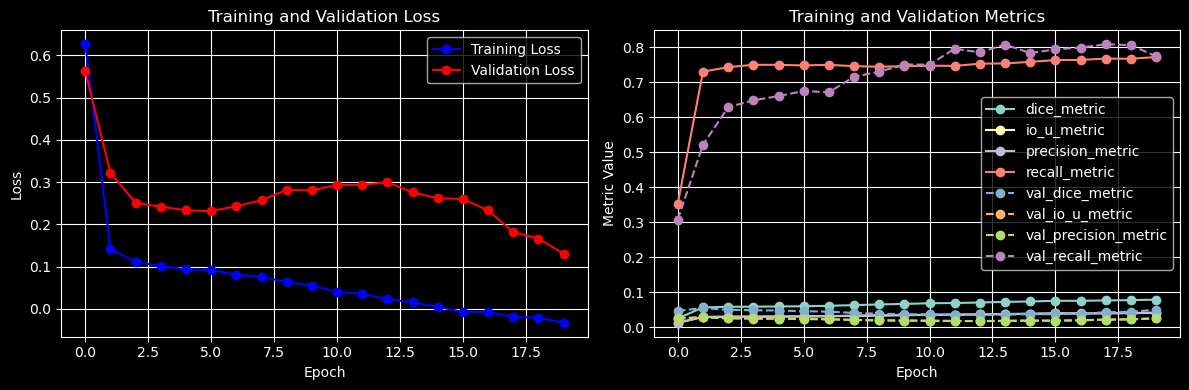

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-o', label='Training Loss')
plt.plot(history.history['val_loss'], 'r-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# All other metrics
plt.subplot(1, 2, 2)
for key in history.history.keys():
    if key not in ['loss', 'val_loss']:
        linestyle = '-' if not key.startswith('val_') else '--'
        plt.plot(history.history[key], label=key, linestyle=linestyle, marker='o')
plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Quick Model Evaluation

In [26]:
test_ds = ((make_dataset(source_dir = data_dir, mode = "test", shuffle = False, batching = False)
           .map(smart_crop_wrapper, num_parallel_calls=tf.data.AUTOTUNE))
           .batch(batch_size).prefetch(tf.data.AUTOTUNE))

test: found 1655 tif files


In [27]:
transfer_model.evaluate(test_ds)

26/26 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - dice_metric: 0.0540 - io_u_metric: 0.0278 - loss: 0.1076 - precision_metric: 0.0281 - recall_metric: 0.7893


[0.10756681114435196,
 0.027814634144306183,
 0.05398515984416008,
 0.02805326133966446,
 0.7893081903457642]